# **Mount Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Necessary Imports**

In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import shutil
import random
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from keras.utils import to_categorical


from tensorflow.keras.layers import Input, Lambda, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard




# **Pre-procesing using List method then Numpy arrays**

In [3]:
X = []
y = []

# Path to the folder containing images
data_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset'

# Iterate through 'yes' and 'no' folders
for label, folder_name in tqdm(enumerate(['yes', 'no'])):
    folder_path = os.path.join(data_folder, folder_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize image to (224, 224)
        X.append(img)
        y.append(label)

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

0it [00:00, ?it/s]

In [4]:
print(len(X), " ", len(y))

1013   1013


In [5]:
print ("Shape of an image in X_train: ", X.shape)
print ("Shape of an image in X_test: ", y.shape)

Shape of an image in X_train:  (1013, 224, 224, 3)
Shape of an image in X_test:  (1013,)


# **Sample Images from our Dataset**

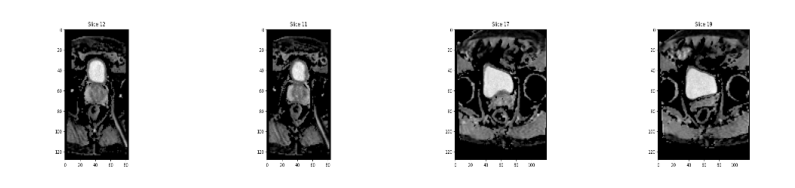

In [6]:
# Display sample images
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()


# **Dataset Split**

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Check shapes
print("Shape of an image in X_train:", X_train[0].shape)
print("Shape of an image in X_test:", X_test[0].shape)
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)


Shape of an image in X_train: (224, 224, 3)
Shape of an image in X_test: (224, 224, 3)
X_train Shape: (678, 224, 224, 3)
X_test Shape: (335, 224, 224, 3)
y_train Shape: (678,)
y_test Shape: (335,)


In [8]:
from sklearn import preprocessing

# Perform label encoding
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Convert to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

print("y_train Shape after label encoding:", y_train.shape)
print("y_test Shape after label encoding:", y_test.shape)


y_train Shape after label encoding: (678,)
y_test Shape after label encoding: (335,)


# **Normalizing Pixel Intensity**

In [9]:
# Normalize pixel values to between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
X_train

In [ ]:
y_test

# **Model**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create a Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add a Flatten layer
model.add(Flatten())

# Add Dense layers with Dropout for preventing overfitting
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                         

# **CheckPoints Calls**

In [ ]:
# Specify the path where you want to create the directory and file
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)


In [ ]:
# 2. Define callbacks for model saving and logging
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'model_{epoch:02d}.h5'),
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Load the weights from the last checkpoint
latest_checkpoint = '/content/drive/MyDrive/Colab Notebooks/Dataset/checkpoints/model_41.h5'
model.load_weights(latest_checkpoint)

# **Training**

In [ ]:
# # Fit the model with callbacks
# history = model.fit(x=X_train,
#                     y=y_train,
#                     batch_size=32,
#                     epochs=50,
#                     validation_data=(X_test, y_test),
#                     callbacks=[checkpoint_callback, early_stopping_callback])


# Fit the model with callbacks starting from epoch 42
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=32,
                    epochs=50,
                    initial_epoch=41,  # Start from epoch 42
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint_callback, early_stopping_callback])


Epoch 42/50
22/22 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9602 
Epoch 42: val_loss improved from inf to 0.14829, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/checkpoints/model_42.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 596s 27s/step - loss: 0.0506 - accuracy: 0.9602 - val_loss: 0.1483 - val_accuracy: 0.9731
Epoch 43/50
22/22 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9720 
Epoch 43: val_loss improved from 0.14829 to 0.08749, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/checkpoints/model_43.h5
22/22 [==============================] - 592s 27s/step - loss: 0.0759 - accuracy: 0.9720 - val_loss: 0.0875 - val_accuracy: 0.9791
Epoch 44/50
22/22 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9631 
Epoch 44: val_loss did not improve from 0.08749
22/22 [==============================] - 588s 27s/step - loss: 0.0571 - accuracy: 0.9631 - val_loss: 0.1009 - val_accuracy: 0.9701
Epoch 45/50
22/22 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9646 
Epoch 45: val_loss did not improve from 0.08749
22/22 [==============================] - 595s 27s/step - loss: 0.0628 - accuracy: 0

# **Model Saved**

In [ ]:
# Save the model to Google Drive
model.save('/content/drive/MyDrive/Colab Notebooks/Dataset/trained_model/vgg16_model_adc.h5')

# **Line Plots for Training Summary**

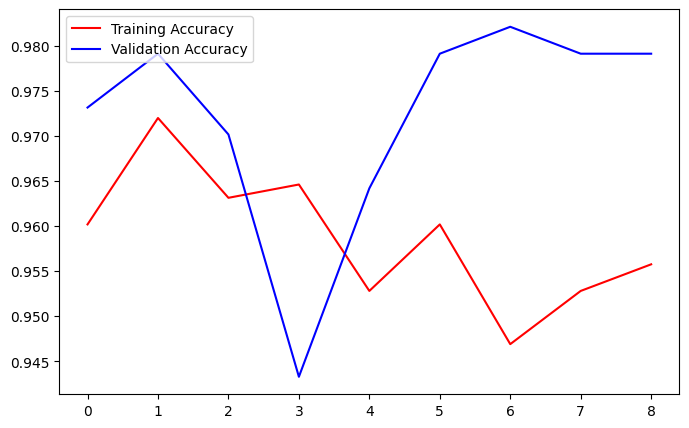

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(8,5))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

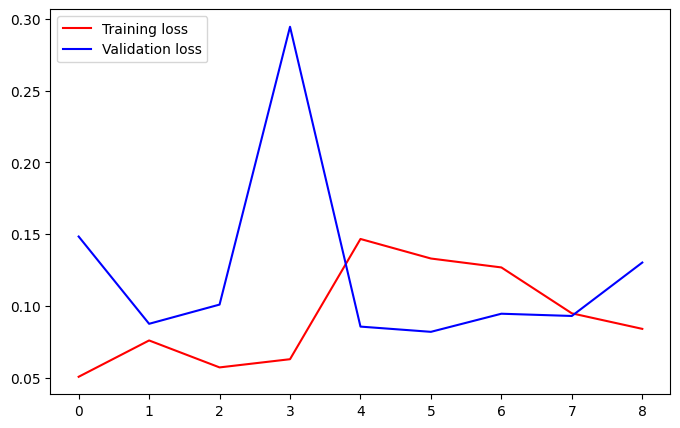

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(8,5))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()


# **Model Loaded and Test Random Prediction**

In [10]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Dataset/trained_model/vgg16_model_adc.h5')


1/1 [==============================] - 1s 559ms/step


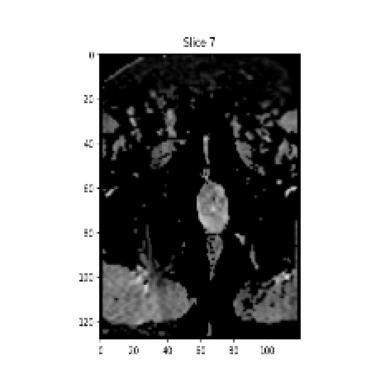

True Label:  No Cancer
Predicted Label: No Cancer


In [34]:
import numpy as np

# Randomly choose an index from X_test
random_index = np.random.randint(0, len(X_test))

# Get the random image and its label
random_image = X_test[random_index]
true_label = y_test[random_index]

# Reshape the image to fit VGG16 input shape
random_image = np.expand_dims(random_image, axis=0)

# Make predictions using the model
predictions = loaded_model.predict(random_image)

# Convert predictions to labels
predicted_label = "Cancer" if predictions[0][0] < 0.5 else "No Cancer"

# Show the image
plt.imshow(random_image[0])
plt.axis('off')
plt.show()

# Print true and predicted labels
print(f'True Label: {"Cancer" if true_label == 0 else " No Cancer"}')
print(f'Predicted Label: {predicted_label}')
